In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

# Load the TCX file
tcx_file = 'activity_16637160557.tcx'
tree = ET.parse(tcx_file)
root = tree.getroot()

# Define namespaces
namespaces = {
    'ns': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2'
}

# Extract data
data = []
for trackpoint in root.findall('.//ns:Trackpoint', namespaces):
    time = trackpoint.find('ns:Time', namespaces).text
    latitude = trackpoint.find('ns:Position/ns:LatitudeDegrees', namespaces)
    longitude = trackpoint.find('ns:Position/ns:LongitudeDegrees', namespaces)
    elevation = trackpoint.find('ns:AltitudeMeters', namespaces)
    heart_rate = trackpoint.find('ns:HeartRateBpm/ns:Value', namespaces)

    # Convert values to appropriate types
    data.append([
        time,
        latitude.text if latitude is not None else None,
        longitude.text if longitude is not None else None,
        elevation.text if elevation is not None else None,
        heart_rate.text if heart_rate is not None else None
    ])

# Convert data to DataFrame
df = pd.DataFrame(data, columns=['Time', 'Latitude', 'Longitude', 'Elevation', 'BPM'])

print(df.head())


FileNotFoundError: [Errno 2] No such file or directory: 'activity_16637160557.tcx'

In [ ]:
import matplotlib.pyplot as plt

# Convert 'Time' to datetime for better plotting
df['Time'] = pd.to_datetime(df['Time'])

# Visualize BPM over time
plt.figure(figsize=(10, 5))
plt.plot(df['Time'], df['BPM'], label='BPM')
plt.xlabel('Time')
plt.ylabel('BPM')
plt.title('Heart Rate Over Time')
plt.legend()
plt.show()

# Simple statistics
print(df['BPM'].describe())


        Time   Elevation  HeartRate   Latitude  Longitude   Distance  \
0        0.0  842.000000         80  46.115734  11.170121   0.000000   
1        1.0  842.000000         80  46.115747  11.170126   1.502650   
2        7.0  841.799988         79  46.115800  11.170080   6.883316   
3       16.0  840.799988         78  46.115894  11.169930  15.581709   
4       21.0  840.599976         81  46.115937  11.169827   9.281836   
...      ...         ...        ...        ...        ...        ...   
1338  1821.0  945.400024        162  46.126418  11.180047   8.700705   
1339  1826.0  945.200012        163  46.126313  11.180211  17.225943   
1340  1831.0  944.200012        162  46.126183  11.180392  20.140210   
1341  1833.0  943.799988        164  46.126103  11.180513  12.883702   
1342  1835.0  943.599976        165  46.126067  11.180581   6.557416   

      CumulativeDistance  FitnessScore   FileName             FileDate  
0               0.000000    428.573804  filip.tcx  2024-08-02 

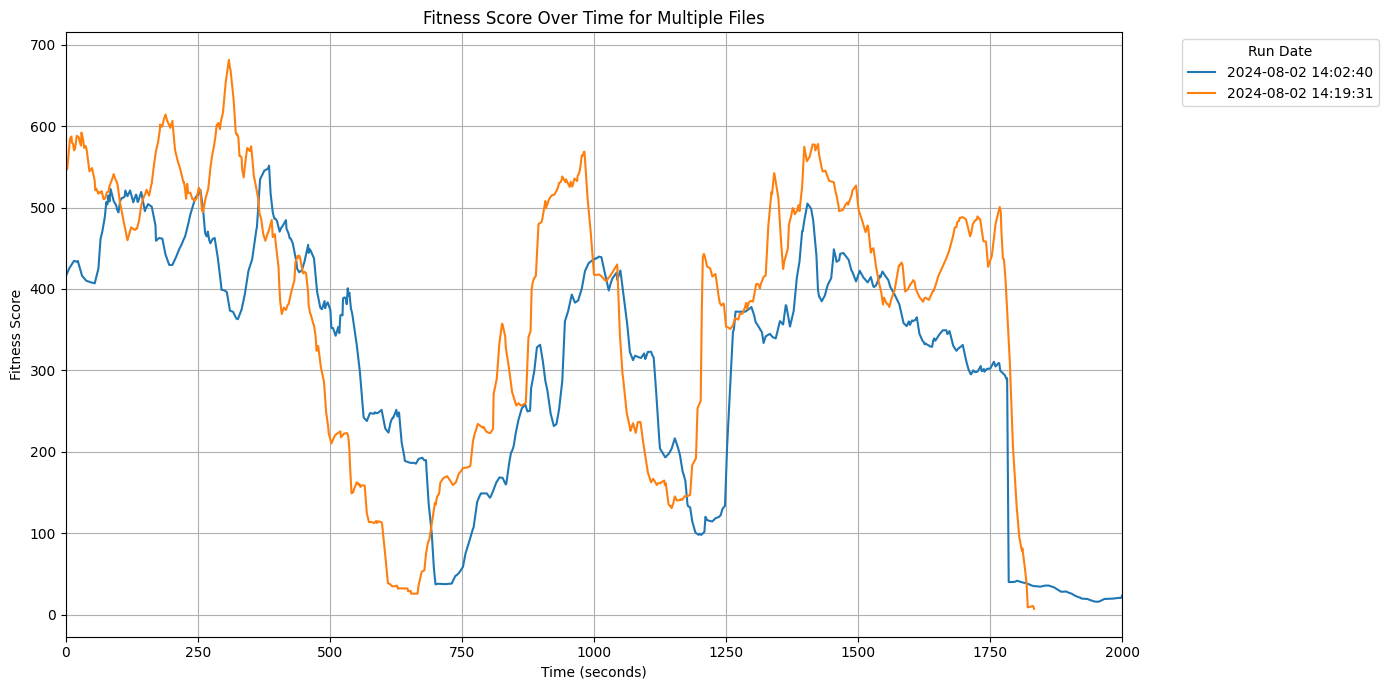

In [2]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_tcx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    namespaces = {'ns': 'http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2'}

    data = []
    for trackpoint in root.findall('.//ns:Trackpoint', namespaces):
        time = trackpoint.find('ns:Time', namespaces).text
        elevation = trackpoint.find('ns:AltitudeMeters', namespaces)
        heart_rate = trackpoint.find('ns:HeartRateBpm/ns:Value', namespaces)
        latitude = trackpoint.find('ns:Position/ns:LatitudeDegrees', namespaces)
        longitude = trackpoint.find('ns:Position/ns:LongitudeDegrees', namespaces)

        data.append([
            time,
            float(elevation.text) if elevation is not None else np.nan,
            int(heart_rate.text) if heart_rate is not None else np.nan,
            float(latitude.text) if latitude is not None else np.nan,
            float(longitude.text) if longitude is not None else np.nan
        ])

    df = pd.DataFrame(data, columns=['Time', 'Elevation', 'HeartRate', 'Latitude', 'Longitude'])
    df['Time'] = pd.to_datetime(df['Time'])  # Convert 'Time' to datetime
    return df.dropna()

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c * 1000  # return in meters

def calculate_cumulative_distance(df):
    df['Distance'] = 0.0
    distances = [0.0]  # First point has zero distance
    for i in range(1, len(df)):
        dist = haversine(df.iloc[i-1]['Latitude'], df.iloc[i-1]['Longitude'],
                         df.iloc[i]['Latitude'], df.iloc[i]['Longitude'])
        distances.append(dist)
    df['Distance'] = distances
    df['CumulativeDistance'] = df['Distance'].cumsum()
    return df

def calculate_fitness_score(df, window_distance=500):
    scores = []
    for i in range(len(df)):
        start_distance = df['CumulativeDistance'].iloc[i]
        end_distance = start_distance + window_distance
        window = df[(df['CumulativeDistance'] >= start_distance) & (df['CumulativeDistance'] < end_distance)]
        if len(window) < 2:
            scores.append(np.nan)
            continue
        total_distance = (window['CumulativeDistance'].iloc[-1] - window['CumulativeDistance'].iloc[0]) / 1000  # in kilometers
        total_time = (window['Time'].iloc[-1] - window['Time'].iloc[0]).total_seconds() / 3600  # in hours
        velocity = total_distance / total_time  # km/h
        average_heart_rate = window['HeartRate'].mean()
        elevation_gain = window['Elevation'].diff().clip(lower=0).sum()
        k = 100  # scaling factor

        fitness_score = k * (velocity / average_heart_rate) * (1 + elevation_gain / total_distance)
        scores.append(fitness_score)
    df['FitnessScore'] = scores
    return df

def align_runs(df_list):
    first_points = [(df.iloc[0]['Latitude'], df.iloc[0]['Longitude']) for df in df_list]
    aligned_dfs = []

    for df in df_list:
        min_dist = float('inf')
        start_idx = 0

        for i, point in enumerate(first_points):
            dist = haversine(df.iloc[0]['Latitude'], df.iloc[0]['Longitude'], point[0], point[1])
            if dist < min_dist:
                min_dist = dist
                start_idx = i

        aligned_df = df.copy()
        aligned_df['Time'] = (aligned_df['Time'] - aligned_df['Time'].iloc[start_idx]).dt.total_seconds()
        aligned_dfs.append(aligned_df)

    return aligned_dfs

def process_tcx_file(file_path):
    df = parse_tcx(file_path)
    df = calculate_cumulative_distance(df)
    df = calculate_fitness_score(df)
    return df

def process_folder(folder_path):
    all_fitness_scores = pd.DataFrame()
    df_list = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tcx'):
            file_path = os.path.join(folder_path, file_name)
            fitness_scores_df = process_tcx_file(file_path)
            fitness_scores_df['FileName'] = os.path.basename(file_path)
            fitness_scores_df['FileDate'] = pd.to_datetime(os.path.getmtime(file_path), unit='s')
            df_list.append(fitness_scores_df)

    aligned_dfs = align_runs(df_list)

    for df in aligned_dfs:
        all_fitness_scores = pd.concat([all_fitness_scores, df], ignore_index=True)

    return all_fitness_scores

# Specify the folder containing the .tcx files
folder_path = '/Users/filippomichelon/Documents/PersonalCode/my_garmin'

# Process all .tcx files in the folder
all_fitness_scores_df = process_folder(folder_path)

# Add a readable date format for legend
all_fitness_scores_df['FileDate'] = all_fitness_scores_df['FileDate'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Display the combined fitness scores
print(all_fitness_scores_df)

# Plot the results for all files with color-coded lines
plt.figure(figsize=(14, 7))
sns.lineplot(x='Time', y='FitnessScore', hue='FileDate', data=all_fitness_scores_df, palette='tab10')
plt.title('Fitness Score Over Time for Multiple Files')
plt.xlabel('Time (seconds)')
plt.ylabel('Fitness Score')
plt.legend(title='Run Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xlim([0,2000])
plt.tight_layout()
plt.show()


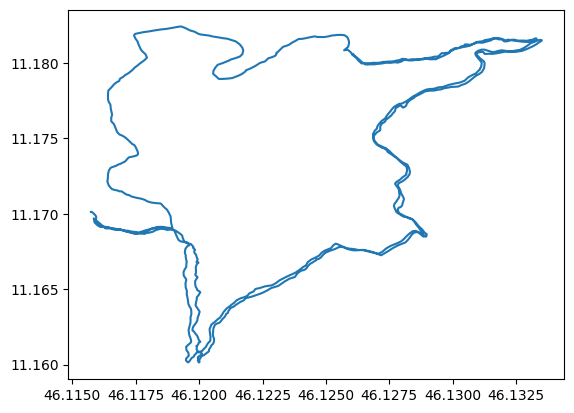

In [3]:
plt.figure()
plt.plot(all_fitness_scores_df.Latitude, all_fitness_scores_df.Longitude, )

/var/folders/lt/qnvxzgp51w14zcg2dl847vqw0000gn/T/ipykernel_47584/3962457896.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


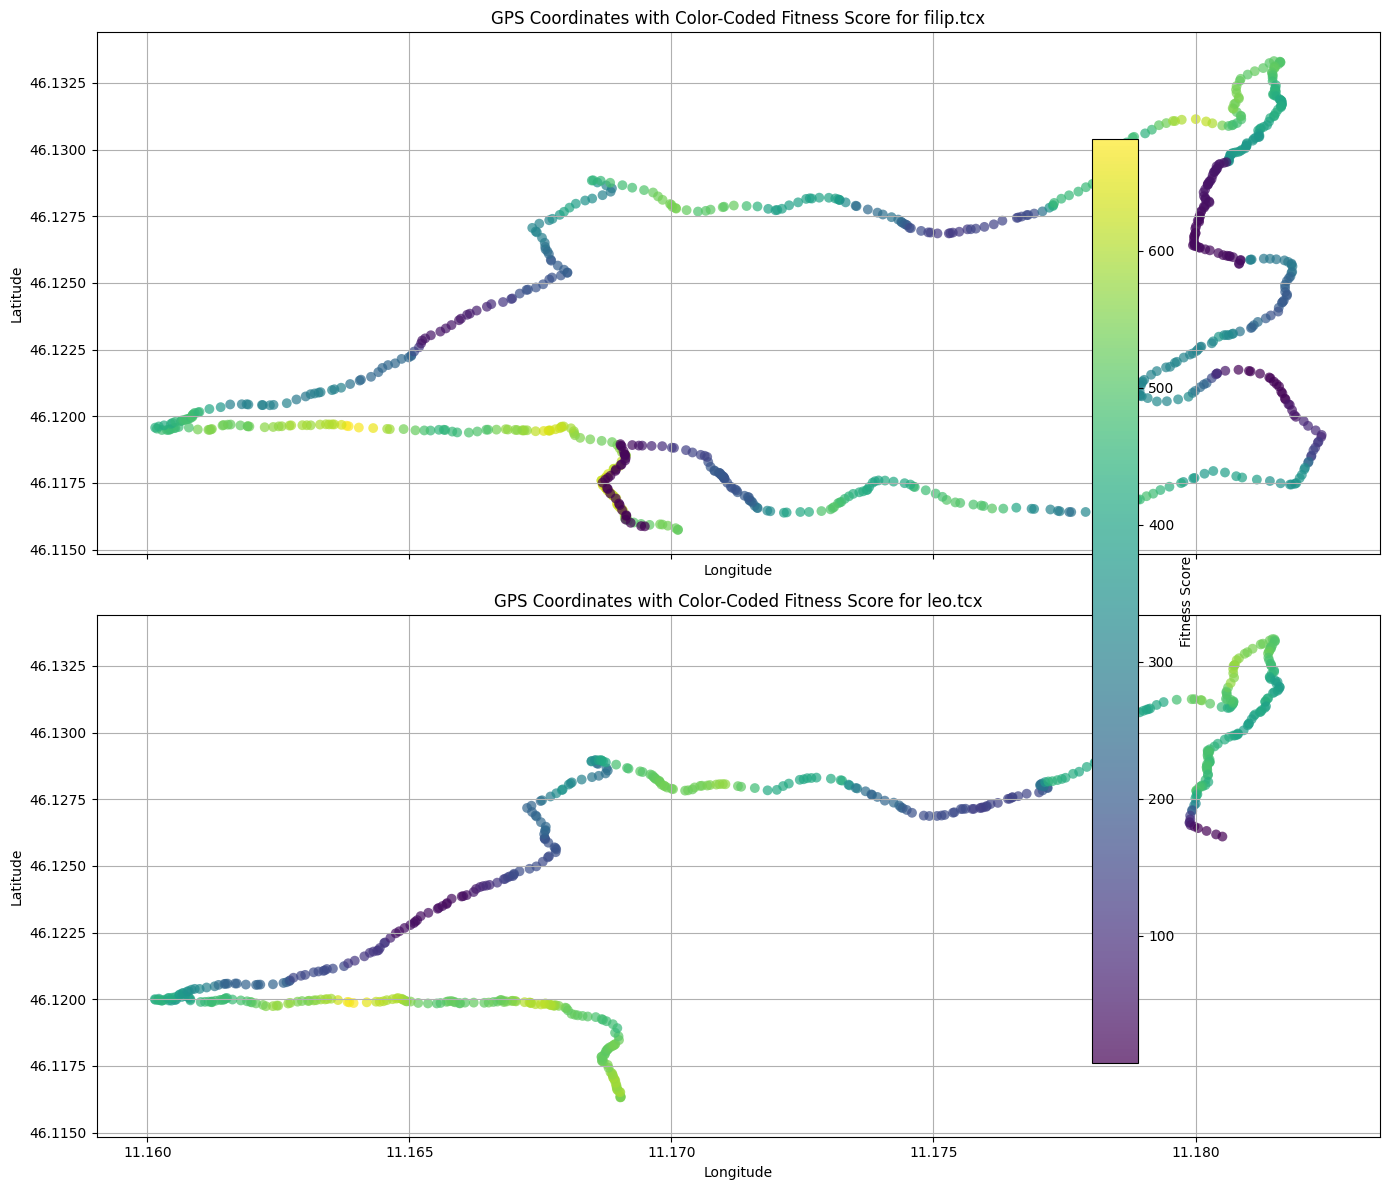

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assume all_fitness_scores_df is already defined and contains the relevant data

# List unique filenames from the DataFrame
file_names = all_fitness_scores_df['FileName'].unique()

# Create a figure with two subplots (adjust the number of subplots as needed)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12), sharex=True, sharey=True)

# Plotting for each file
for i, file_name in enumerate(file_names):
    df_file = all_fitness_scores_df[all_fitness_scores_df['FileName'] == file_name]
    
    # Normalize fitness score for colormap
    norm = plt.Normalize(df_file['FitnessScore'].min(), df_file['FitnessScore'].max())
    cmap = plt.get_cmap('viridis')

    # Plotting GPS coordinates with color-coded fitness score
    sc = axes[i].scatter(df_file['Longitude'], df_file['Latitude'], c=df_file['FitnessScore'], cmap=cmap, norm=norm, s=50, edgecolor='none', alpha=0.7)
    
    # Set titles and labels
    axes[i].set_title(f'GPS Coordinates with Color-Coded Fitness Score for {file_name}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    axes[i].grid(True)

# Add a single color bar for the whole figure
cbar = plt.colorbar(sc, ax=axes, orientation='vertical', label='Fitness Score', pad=0.02)
cbar.set_label('Fitness Score')

plt.tight_layout()
plt.show()
